In [120]:
import os
from pathlib import Path
import pandas as pd
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
plt.style.use('seaborn-white')

while Path.cwd().name != 'cartography':
    %cd ..

In [25]:
from cartography.selection.selection_utils import read_training_dynamics

HOME_DIR = Path('/gscratch/xlab/alisaliu/cartography')

In [113]:
model_dir = HOME_DIR / 'output/mnli'
train_dy_filename = os.path.join(model_dir, "td_metrics.jsonl")

training_dynamics = read_training_dynamics(model_dir)
train_dy_metrics = pd.read_json(train_dy_filename, lines=True)

2021-02-28 13:19:52,328 - INFO - cartography.selection.selection_utils - Reading 5 files from /gscratch/xlab/alisaliu/cartography/output/mnli/training_dynamics ...
100%|██████████| 5/5 [00:11<00:00,  2.24s/it]
2021-02-28 13:20:03,514 - INFO - cartography.selection.selection_utils - Read training dynamics for 392702 train instances.


In [114]:
train_dy_metrics

,guid,index,threshold_closeness,confidence,variability,correctness,forgetfulness
0,774943,0,0.248558,0.537971,0.238491,3,0
1,3864203,1,0.224791,0.341228,0.240970,2,2
2,1829693,2,0.127562,0.849912,0.292343,4,0
3,1474023,3,0.131230,0.844630,0.303814,4,0
4,3685553,4,0.124403,0.854397,0.289226,4,0
...,...,...,...,...,...,...,...
392697,3032883,392697,0.140144,0.831445,0.132822,5,0
392698,1766013,392698,0.249989,0.496754,0.301296,3,0
392699,108403,392699,0.006550,0.993406,0.002688,5,0
392700,1095893,392700,0.229187,0.355734,0.373817,2,0


In [30]:
training_dynamics

{774943: {'gold': 1,
  'logits': [[-0.0640878007, -0.1315077841, 0.5524407029],
   [1.1222144365, 0.792417407, -2.0997049809],
   [1.1534698009, 1.2787476778, -2.9946942329],
   [1.6271500587, 1.8001533747, -3.2737994194],
   [-0.5141144991, 2.9108607769, -2.853716135]]},
 3864203: {'gold': 2,
  'logits': [[-0.1075840071, -0.3401796222, 0.3498663008],
   [-0.9927049875, 0.7086950541, 0.0093207024],
   [-1.605881691, 1.3194503784, -0.4569500089],
   [-2.8610076904, 0.7333060503, 1.7860097885],
   [-1.5473985672, 1.7997412682, -0.7948460579]]},
 1829693: {'gold': 1,
  'logits': [[-0.1643601358, -0.1731937379, 0.392873764],
   [-1.856656909, 3.7157902718, -2.0230898857],
   [-2.3555703163, 4.1629872322, -2.181319952],
   [-1.699054718, 4.1512846947, -2.4199750423],
   [-2.3720338345, 4.8879156113, -2.6663975716]]},
 1474023: {'gold': 1,
  'logits': [[0.0159311816, -0.2278991491, 0.436360985],
   [-3.2205190659, 3.7693507671, -1.4276407957],
   [-3.36241889, 4.4973034859, -1.6638875008],
 

## compare different metrics

In [75]:
new_metrics = []

for guid in tqdm(training_dynamics):
    record = training_dynamics[guid]
    probs_per_label = {i: [] for i in range(3)}
    for i, epoch_logits in enumerate(record['logits']):
        probs = torch.nn.functional.softmax(torch.Tensor(epoch_logits), dim=-1)
        for label in range(3):
            probs_per_label[label].append(float(probs[label]))
        
    epoch_logits = record['logits'][-1]
    probs = torch.nn.functional.softmax(torch.Tensor(epoch_logits), dim=-1)
    true_class_prob = float(probs[record["gold"]])
    label_prob = probs.max().item()
    mean_variability = np.mean([np.std(probs_per_label[label]) for label in range(3)])
    
    new_metrics.append({'guid': guid, 'last_confidence': true_class_prob, 'last_label_confidence': label_prob, 'mean_variability': mean_variability})

100%|██████████| 392702/392702 [01:17<00:00, 5072.57it/s]


In [79]:
train_dy_metrics = train_dy_metrics.merge(pd.DataFrame(new_metrics), on='guid')

-0.3354463067336021

<Figure size 432x288 with 0 Axes>

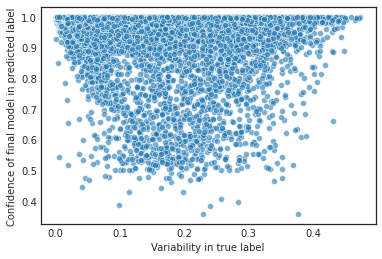

In [84]:
plt.figure()
fig, ax = plt.subplots()
x = 'variability'
y = 'last_label_confidence'
df = train_dy_metrics.sample(n=25000)
sns.scatterplot(x=x, y=y, data=df, alpha=0.6)
ax.set_xlabel('Variability in true label')
ax.set_ylabel('Confidence of final model in predicted label')
df[x].corr(df[y])

0.5894286794148259

<Figure size 432x288 with 0 Axes>

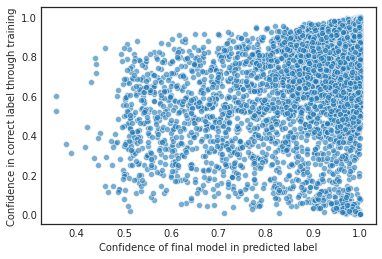

In [81]:
plt.figure()
fig, ax = plt.subplots()
x = 'last_label_confidence'
y = 'confidence'
sns.scatterplot(x=x, y=y, data=df, alpha=0.6)
ax.set_ylabel('Confidence in correct label through training')
ax.set_xlabel('Confidence of final model in predicted label')
df[x].corr(df[y])

0.7644217655152301

<Figure size 432x288 with 0 Axes>

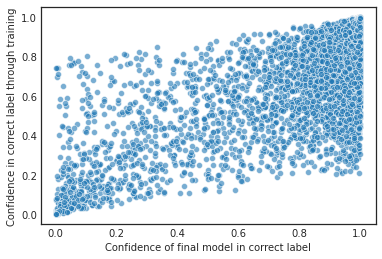

In [82]:
plt.figure()
fig, ax = plt.subplots()
x = 'last_confidence'
y = 'confidence'
sns.scatterplot(x=x, y=y, data=df, alpha=0.6)
ax.set_ylabel('Confidence in correct label through training')
ax.set_xlabel('Confidence of final model in correct label')
df[x].corr(df[y])

0.986917770158441

<Figure size 432x288 with 0 Axes>

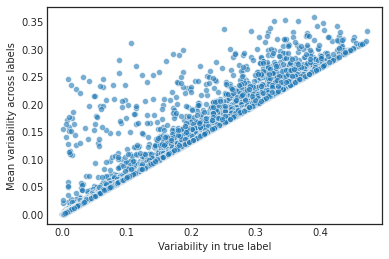

In [83]:
plt.figure()
fig, ax = plt.subplots()
x = 'variability'
y = 'mean_variability'
sns.scatterplot(x=x, y=y, data=df, alpha=0.6)
ax.set_ylabel('Mean variability across labels')
ax.set_xlabel('Variability in true label')
df[x].corr(df[y])

## compare models

In [92]:
models = {
    'seed_18': {
        'model_dir': HOME_DIR / 'output/mnli_seed_18'
    },
    'seed_20': {
        'model_dir': HOME_DIR / 'output/mnli_seed_20'
    }
}

In [99]:
train_dy_filename = os.path.join(models['seed_18']['model_dir'], "td_metrics.jsonl")
train_dy_metrics18 = pd.read_json(train_dy_filename, lines=True)
train_dy_metrics18 = train_dy_metrics18.drop('index', axis=1)
train_dy_filename = os.path.join(models['seed_20']['model_dir'], "td_metrics.jsonl")
train_dy_metrics20 = pd.read_json(train_dy_filename, lines=True)
train_dy_metrics20 = train_dy_metrics20.drop('index', axis=1)

In [101]:
merged_df = train_dy_metrics18.merge(train_dy_metrics20, on=['guid'])

0.9253175555395431

<Figure size 432x288 with 0 Axes>

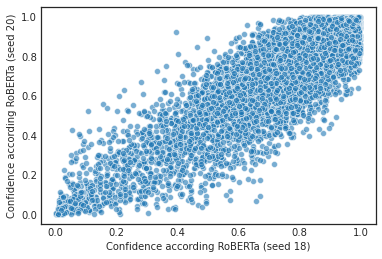

In [110]:
plt.figure()
fig, ax = plt.subplots()
df = merged_df.sample(n=25000)
dy = 'confidence'
sns.scatterplot(x=f'{dy}_x', y=f'{dy}_y', data=df, alpha=0.6)
ax.set_xlabel(f'{dy.capitalize()} according RoBERTa (seed 18)')
ax.set_ylabel(f'{dy.capitalize()} according RoBERTa (seed 20)')
df[f'{dy}_x'].corr(df[f'{dy}_y'])

0.6795412081968604

<Figure size 432x288 with 0 Axes>

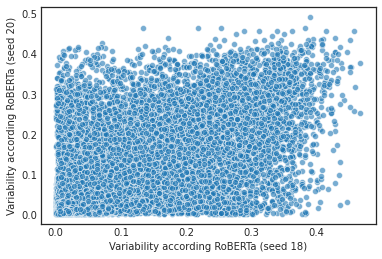

In [111]:
plt.figure()
fig, ax = plt.subplots()
dy = 'variability'
sns.scatterplot(x=f'{dy}_x', y=f'{dy}_y', data=df, alpha=0.6)
ax.set_xlabel(f'{dy.capitalize()} according RoBERTa (seed 18)')
ax.set_ylabel(f'{dy.capitalize()} according RoBERTa (seed 20)')
df[f'{dy}_x'].corr(df[f'{dy}_y'])

## what do high variability examples look like?

In [118]:
guids = list(train_dy_metrics.loc[train_dy_metrics['correctness'] == 3]['guid'])

In [121]:
correctness_pattern = defaultdict(int)

for guid in guids:
    record = training_dynamics[guid]
    label = record['gold']
    pattern = []
    for i, epoch_logits in enumerate(record['logits']):
        pred = np.argmax(epoch_logits)
        pattern.append(pred == label)
    
    correctness_pattern[str(pattern)] += 1

In [122]:
correctness_pattern

defaultdict(int,
            {'[False, False, True, True, True]': 7552,
             '[False, True, True, True, False]': 623,
             '[False, True, False, True, True]': 2561,
             '[True, False, False, True, True]': 1082,
             '[False, True, True, False, True]': 1189,
             '[True, True, False, False, True]': 284,
             '[True, False, True, False, True]': 522,
             '[True, True, True, False, False]': 128,
             '[True, False, True, True, False]': 307,
             '[True, True, False, True, False]': 201})